# Lab 7: Measurement Error mitigation using Noise Models and IBMQ
    by Muhammad Faryad

In [1]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import qasm_simulator

import numpy as np

In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

p=0.02
error_meas = pauli_error([('X',p), ('I', 1 - p)])


noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_meas, "measure")





{'000': 9421, '001': 185, '010': 195, '011': 5, '100': 189, '101': 4, '110': 1}


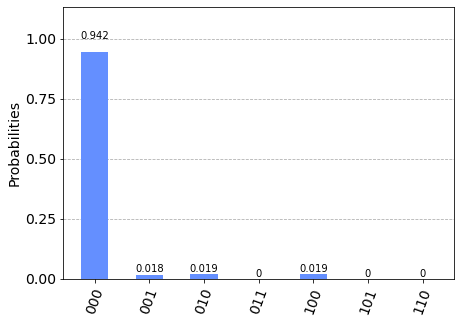

In [5]:
qc=QuantumCircuit(3,3)
for i in range(3):
    qc.measure(i,i)

    
simulator =Aer.get_backend('qasm_simulator')
noisy_results = execute(qc, backend=simulator, shots=10000, noise_model=noise_model).result()
noisy_counts=noisy_results.get_counts()
print(noisy_counts)
plot_histogram(noisy_counts)

In [6]:
simulator = Aer.get_backend('qasm_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    
    counts = execute(qc, backend=simulator, shots=1000,noise_model=noise_model).result().get_counts()
    print(state+' becomes', counts)


00 becomes {'00': 949, '01': 23, '10': 28}
01 becomes {'00': 28, '01': 951, '11': 21}
10 becomes {'00': 12, '10': 969, '11': 19}
11 becomes {'01': 13, '10': 21, '11': 966}


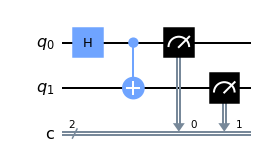

In [7]:
qc=QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])
qc.draw('mpl')

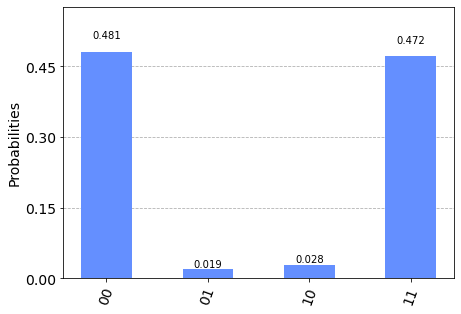

In [9]:
noisy_results = execute(qc, backend=simulator, shots=1000,noise_model=noise_model).result()
noisy_counts=noisy_results.get_counts()
plot_histogram(noisy_counts)

In [11]:
from qiskit import QuantumRegister
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [12]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q16_0: ─░─┤M├───
        ░ └╥┘┌─┐
q16_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c1: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q16_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q16_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q16_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q16_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q16_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q16_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c1: 2/═════════╩══╩═
                0  1 



In [18]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer, transpile, assemble
t_qc = transpile(meas_calibs, simulator)
cal_results =execute(t_qc,backend=simulator,noise_model=noise_model, shots=1000).result()

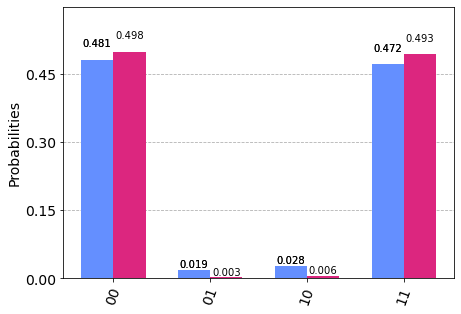

In [21]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noisy_counts,mitigated_counts])

In [22]:
from qiskit import IBMQ
IBMQ.save_account('b7c3d5261ffcdc9163d35371670119c46adb48436e35147c205928aa37c913fcbee976e715f8547f637f98adaff39dee787ff1b5038bac14d34fd69cd8937e28', overwrite=True)

In [23]:
provider=IBMQ.load_account()
backend=provider.get_backend('ibmq_quito')

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


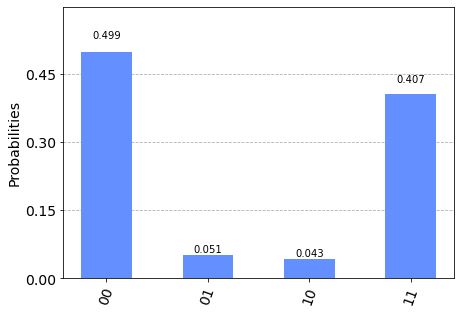

In [25]:
noisy_results = execute(qc, backend=backend, shots=1000).result()
noisy_counts=noisy_results.get_counts()
plot_histogram(noisy_counts)

In [26]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer, transpile, assemble
t_qc = transpile(meas_calibs, backend)
cal_results =execute(t_qc,backend=backend, shots=1000).result()


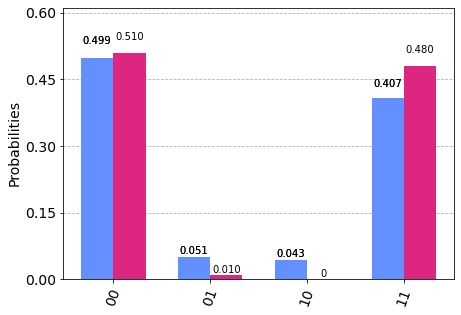

In [27]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noisy_counts,mitigated_counts])